# First preliminary analysis of the same plate cell painting data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import fastcluster  
from sklearn.preprocessing import StandardScaler
import polars as pl

For the treatement of raw data, we use the notebook 03 of Exploratory Analysis. To compute the manuscript results here are the codes to run. 

## Normalized data

In [ ]:
## load the normalized data

norm_data = pl.read_parquet("../00.exploratory_analysis/inputs/CP_data/normalized_new.parquet")
norm_data = norm_data.to_pandas()


In [ ]:
## deleting the rows that are empty from 'Metadata_BROAD_ID' (untreated ones) and replacing the empty values of Compound Name and Annotation with DMSO

norm_data = norm_data[norm_data['Metadata_BROAD_ID'] != 'EMPTY']
norm_data.loc[norm_data['Metadata_BROAD_ID'] == 'DMSO', 'Metadata_Compound Name'] = 'DMSO'
norm_data.loc[norm_data['Metadata_BROAD_ID'] == 'DMSO', 'Metadata_Annotation'] = 'DMSO'

In the CP data, there are 9 Jump controls, 11 negatives controls, 16 positive controls, DMSO + untreated wells. 

In [10]:
# some counts 
unique_compounds = norm_data['Metadata_Compound Name'].nunique()
print(f"Number of unique compounds: {unique_compounds}")

compound_annotations = norm_data[['Metadata_Compound Name', 'Metadata_Annotation']].drop_duplicates()
compound_annotations_sorted = compound_annotations.sort_values(by='Metadata_Annotation')
print(compound_annotations_sorted)


Number of unique compounds: 37
                      Metadata_Compound Name Metadata_Annotation
1                                       DMSO                DMSO
0                                    AMG 900        JUMP control
336                              Aloxistatin        JUMP control
314                                Imiquimod        JUMP control
48                                NVS-PAK1-1        JUMP control
288                                TC-S 7004        JUMP control
240                                Quinidine        JUMP control
96                      Dexamethasone (DHAP)        JUMP control
192                                   FK-866        JUMP control
144                                LY2109761        JUMP control
290                     PEMIROLAST POTASSIUM    negative control
266                 Nedocromil (sodium salt)    negative control
228  Colistin Methanesulfonate (sodium salt)    negative control
338                              MILTEFOSINE    negative co

In [11]:
## we drop the metadata columns to keep only the CP features (here 688 x 720)

norm_signal_filtered = norm_data.drop(columns=[col for col in norm_data.columns if col.startswith("Metadata")])
norm_signal_filtered

,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_2_2,...,Nuclei_Texture_InfoMeas1_RNA_10_03_256,Nuclei_Texture_InfoMeas2_AGP_10_03_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_DNA_10_01_256,Nuclei_Texture_InfoMeas2_ER_10_01_256,Nuclei_Texture_InfoMeas2_RNA_10_03_256,Nuclei_Texture_InfoMeas2_RNA_5_01_256,Nuclei_Texture_InverseDifferenceMoment_AGP_10_01_256,Nuclei_Texture_InverseDifferenceMoment_RNA_10_02_256,Nuclei_Texture_SumAverage_Brightfield_10_00_256
0,-1.129100,0.38244,0.26427,-0.87933,0.43508,-0.775620,0.228060,-0.430290,0.43794,0.43017,...,1.824100,-0.12124,-0.19153,-0.054714,-0.236470,-0.91800,-1.39680,0.19934,1.711500,-0.048063
1,0.023428,1.64800,2.18260,0.58407,-2.18020,0.355980,-1.067100,-0.945140,-1.03890,-0.91881,...,0.762120,-0.46083,-0.79834,0.751130,0.657340,0.42925,-0.12102,1.63270,-0.070211,1.483600
22,-1.821200,0.30099,-0.49611,-2.12500,1.07300,0.977310,0.294750,0.693860,-0.57220,1.11790,...,-0.596720,-1.65760,-0.78913,-1.884000,-2.097000,-1.91860,-0.31939,-0.19934,0.014963,-1.579700
23,-1.168500,1.02220,0.62704,0.78337,-1.04590,-0.055939,-0.940200,-0.282930,0.14385,-0.99399,...,0.019991,-0.79855,-1.10870,0.669130,1.068400,1.32240,0.73028,2.43260,-0.887430,2.105200
24,-1.423400,-1.79900,-1.56400,1.12850,1.23360,-2.178100,1.213400,0.958360,1.62070,-0.28956,...,1.870100,0.92825,-0.25875,1.190600,0.948330,-0.16118,-1.52790,-0.28877,1.547300,0.426160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0.558450,1.50380,0.55200,0.94315,-0.77558,-0.351300,-0.235120,0.028935,0.78541,-3.23540,...,0.343360,-0.76999,-0.21360,-0.051671,0.052273,0.10971,0.56156,0.38729,-0.499940,2.402400
744,-0.930460,-0.22562,-0.56462,-0.75206,0.36960,-0.335020,-0.064124,0.526300,0.20385,0.51332,...,-0.168190,-0.09124,0.23647,0.670680,0.560160,0.93014,0.54915,0.25117,-0.934080,-0.267850
745,0.020051,-0.80892,-0.55515,0.59881,0.57502,0.067815,0.242250,0.040665,0.22183,0.71212,...,-0.257300,1.36180,0.97155,1.159500,0.951370,1.16610,0.46600,-0.77432,-0.111450,-0.306710
766,-0.116470,3.07610,2.61380,-0.65557,-2.94300,0.337210,-2.384500,-1.760300,-2.15840,-1.41790,...,1.288300,-3.04440,-2.09120,-0.367080,-0.603330,-0.32362,-0.60375,2.60590,-0.564390,0.886830


***Section 1.2 and Figure S5***

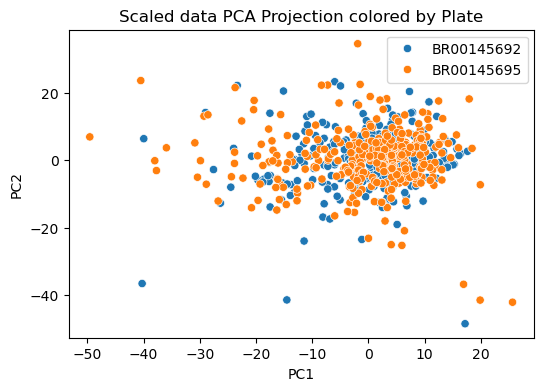

In [12]:
## scaled data PCA

scaler = StandardScaler()
scaled = scaler.fit_transform(norm_signal_filtered)

pca = PCA(n_components=20)
principal_components = pca.fit_transform(scaled)


column_names = [f'PC{i+1}' for i in range(20)]
pca_df = pd.DataFrame(data=principal_components, columns=column_names, index=norm_signal_filtered.index)


pca_df['Plate'] = norm_data.loc[norm_signal_filtered.index, 'Metadata_Plate']
pca_df['Compound'] = norm_data.loc[norm_signal_filtered.index, 'Metadata_Compound Name']
pca_df['Concentration'] = norm_data.loc[norm_signal_filtered.index, 'Metadata_assay_conc_uM']

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Plate'], palette="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scaled data PCA Projection colored by Plate")
plt.legend(bbox_to_anchor=(0.67, 1), loc='upper left')
plt.show()

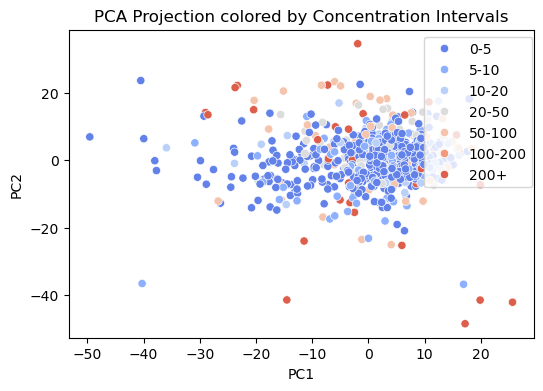

In [13]:
##scaled data PCA colored by concentration intervals

bins = [0, 5, 10, 20, 50, 100, 200, 300] 
labels = ['0-5', '5-10', '10-20', '20-50', '50-100', '100-200', '200+']  


pca_df['Concentration_Binned'] = pd.cut(pca_df['Concentration'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Concentration_Binned'], palette="coolwarm")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Concentration Intervals")
plt.legend(bbox_to_anchor=(0.75, 1), loc='upper left')
plt.show()

['Compound' 'DMSO']


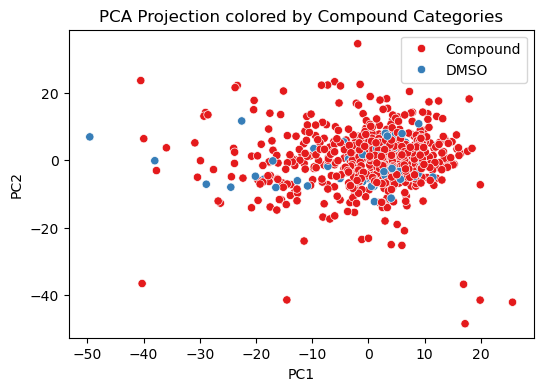

In [14]:
# scaled data PCA by compound categories

pca_df['Category'] = pca_df['Compound'].apply(
    lambda x: 'DMSO' if x == 'DMSO' else ('Compound')
)


print(pca_df['Category'].unique())

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Category'], palette="Set1")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Compound Categories")
plt.legend(bbox_to_anchor=(0.7, 1), loc='upper left')
plt.show()



# Cell Count 

***Section Image-based profile processing : Materials and Methods***

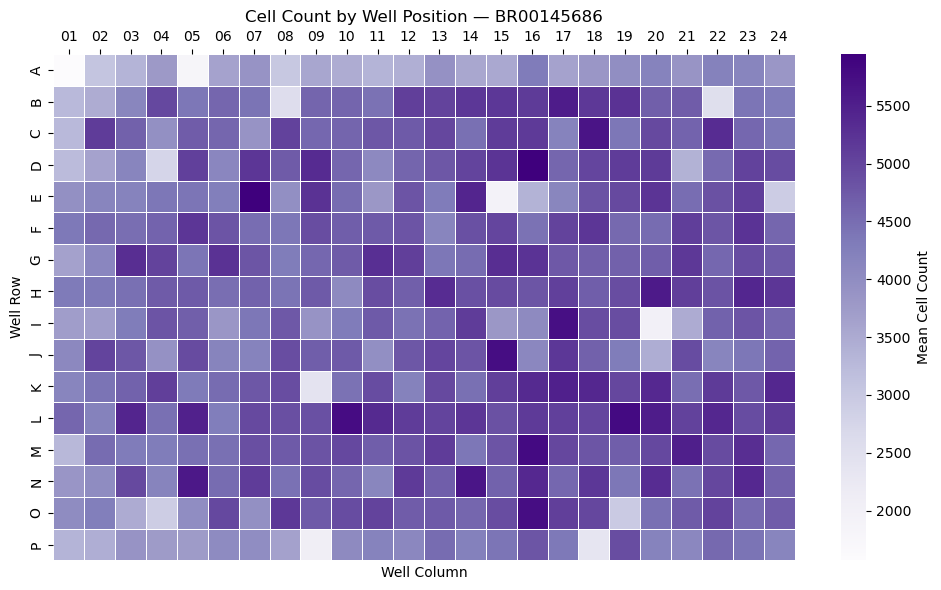

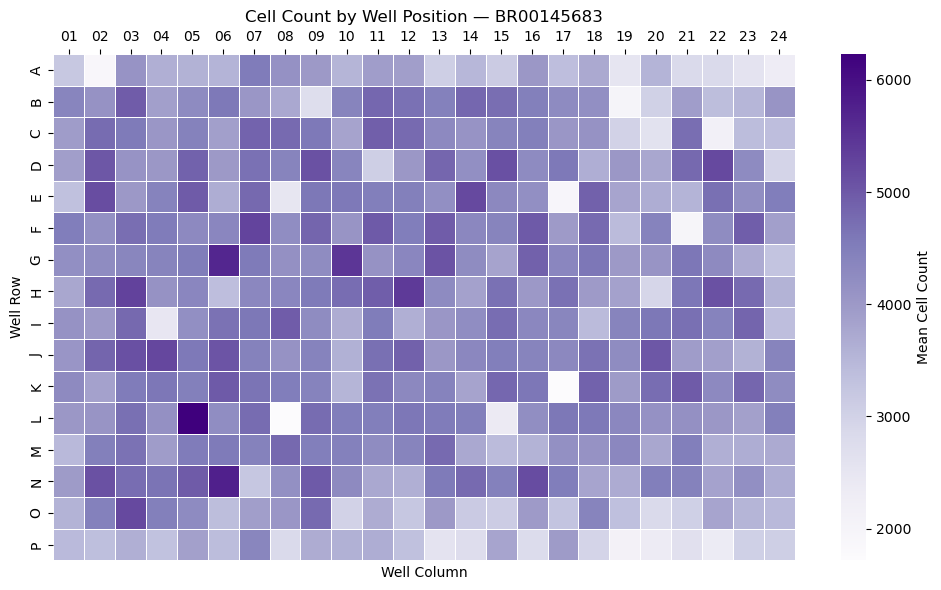

In [15]:
df = pd.read_csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/01.dose_response/outputs/df_CC_Proba.csv", sep=',')

df["Well_Row"] = df["Metadata_Well"].str.extract(r"([A-P])")
df["Well_Col"] = df["Metadata_Well"].str.extract(r"(\d{2})")

row_order = list("ABCDEFGHIJKLMNOP")

plates = df["Metadata_Plate"].unique()
for plate in plates:
    sub_df = df[df["Metadata_Plate"] == plate]
    heatmap_data = (
                sub_df.groupby(["Well_Row", "Well_Col"])["Metadata_Count_Cells"]
                .mean()
                .unstack()
                .reindex(index=row_order)
            )

    plt.figure(figsize=(10,6))
    sns.heatmap(
        heatmap_data,
        cmap= 'Purples',
        linewidths=0.5,
        linecolor="white",
        cbar_kws={"label": "Mean Cell Count"},
    )
    plt.title(f"Cell Count by Well Position — {plate}")
    plt.xlabel("Well Column")
    plt.ylabel("Well Row")
    plt.gca().xaxis.tick_top()
    plt.tight_layout()
    plt.show()

/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_3990/3293514485.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Metadata_Plate", y="Metadata_Count_Cells", palette="muted")


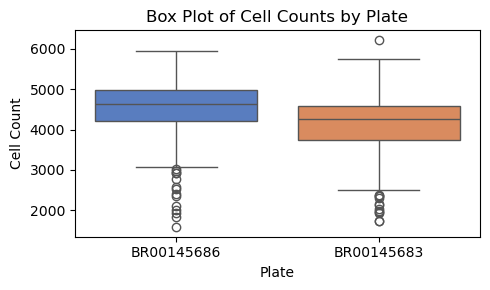

In [16]:
plt.figure(figsize=(5,3))
sns.boxplot(data=df, x="Metadata_Plate", y="Metadata_Count_Cells", palette="muted")
plt.title("Box Plot of Cell Counts by Plate")
plt.xlabel("Plate")
plt.ylabel("Cell Count")
plt.tight_layout()
plt.show()

### Normalized count cell

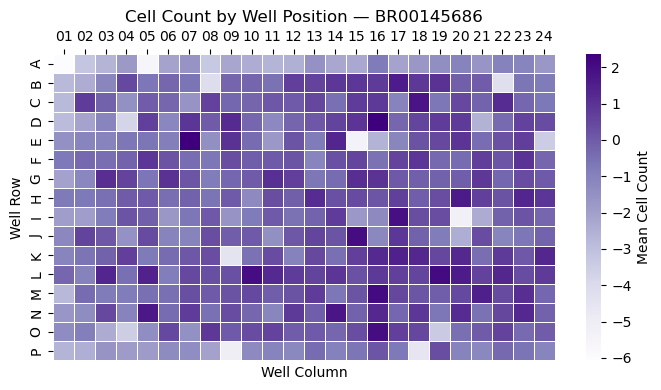

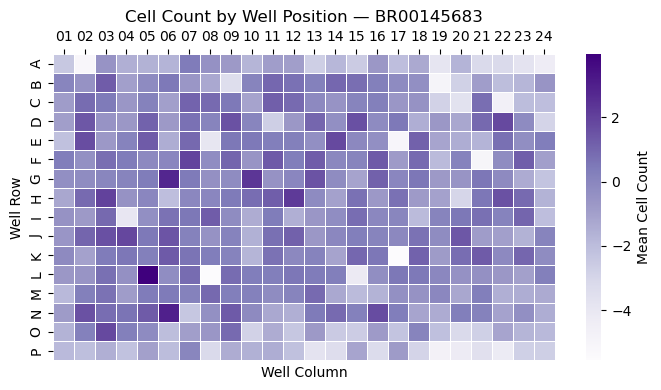

In [11]:
plates = df["Metadata_Plate"].unique()
for plate in plates:
    sub_df = df[df["Metadata_Plate"] == plate]
    heatmap_data = (
                sub_df.groupby(["Well_Row", "Well_Col"])["Metadata_Count_Cells_Normalized"]
                .mean()
                .unstack()
                .reindex(index=row_order)
            )

    plt.figure(figsize=(7,4))
    sns.heatmap(
        heatmap_data,
        cmap= 'Purples',
        linewidths=0.5,
        linecolor="white",
        cbar_kws={"label": "Mean Cell Count"},
    )
    plt.title(f"Cell Count by Well Position — {plate}")
    plt.xlabel("Well Column")
    plt.ylabel("Well Row")
    plt.gca().xaxis.tick_top()
    plt.tight_layout()
    plt.show()

/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_5271/570941148.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Metadata_Plate", y="Metadata_Count_Cells_Normalized", palette="muted")


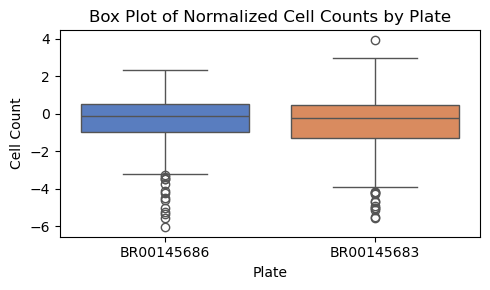

In [12]:
plt.figure(figsize=(5,3))
sns.boxplot(data=df, x="Metadata_Plate", y="Metadata_Count_Cells_Normalized", palette="muted")
plt.title("Box Plot of Normalized Cell Counts by Plate")
plt.xlabel("Plate")
plt.ylabel("Cell Count")
plt.tight_layout()
plt.show()